In [ ]:
# Iris Presentation Attack Detection Using Deep Learning
# Summer Enrichment Program 2024
# -----------------------------------------------------
# Rasel Ahmed Bhuiyan, July 2024

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define the dataset class

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Split dataset for train, test, and validation

In [4]:
def load_and_split_data(root_dir, test_size=0.2, val_size=0.2):
    image_paths = []
    labels = []
    for label, subdir in enumerate(['bonafide', 'attack']):
        subdir_path = os.path.join(root_dir, subdir)
        for fname in tqdm(os.listdir(subdir_path), desc=f'Loading {subdir} images'):
            image_paths.append(os.path.join(subdir_path, fname))
            labels.append(label)

    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=test_size, stratify=labels
    )

    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=val_size, stratify=train_labels
    )

    return train_paths, val_paths, test_paths, train_labels, val_labels, test_labels

# Load Data

In [ ]:
# Follow the subdirectory name as it is

# root_dir/
#    |- bonafide/
#    |   |- image1.jpg
#    |   |- image2.jpg
#    |- attack/
#    |   |- image3.jpg
#    |   |- image4.jpg

In [5]:
root_dir = '/content/drive/MyDrive/Iris-Presentation-Attack/dataset'
best_model_path = '/content/drive/MyDrive/Iris-Presentation-Attack/best_model.pth'
batch_size = 32

# Data transforms
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_paths, val_paths, test_paths, train_labels, val_labels, test_labels = load_and_split_data(root_dir)

train_dataset = CustomImageDataset(train_paths, train_labels, transform)
val_dataset = CustomImageDataset(val_paths, val_labels, transform)
test_dataset = CustomImageDataset(test_paths, test_labels, transform)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

print(f'\n\n{dataset_sizes}')

Loading attack images: 100%|██████████| 2151/2151 [00:00<00:00, 576961.56it/s]



{'train': 3089, 'val': 773, 'test': 966}


# Check GPU is available or not

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Current device: {device}')

Current device: cuda


# Training function

In [7]:
# Model training function
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            phase_loader = tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch+1}', leave=False)
            for inputs, labels in phase_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                batch_acc = (running_corrects / dataset_sizes[phase]).cpu().numpy()

                phase_loader.set_postfix(loss=f'{running_loss / dataset_sizes[phase]:.3f}', acc=f'{batch_acc:.3f}')


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.3f} Acc: {epoch_acc:.3f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_path)

        # print()

# Evaluation function

In [8]:
def evaluate_model(model, dataloaders, dataset_sizes):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    bona_fide_scores = []
    attack_scores = []

    with torch.no_grad():
        test_loader = tqdm(dataloaders['test'], desc='Testing')
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_scores.extend(outputs[:, 1].cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            for i in range(len(labels)):
                if labels[i] == 0:  # Bona fide
                    bona_fide_scores.append(outputs[i, 1].item())
                else:  # Attack
                    attack_scores.append(outputs[i, 1].item())

    return y_true, y_pred, y_scores, bona_fide_scores, attack_scores


# Build classifier

In [10]:
# Load pre-trained ResNet18 model
model = models.resnet18(weights='DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

# Train model

In [ ]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=num_epochs)

Epoch 1/10
----------


train Loss: 0.009 Acc: 0.997


val Loss: 0.046 Acc: 0.994
Epoch 2/10
----------


train Loss: 0.000 Acc: 1.000


val Loss: 0.051 Acc: 0.999
Epoch 3/10
----------


train Loss: 0.000 Acc: 1.000


val Loss: 0.042 Acc: 0.999
Epoch 4/10
----------


train Loss: 0.000 Acc: 1.000


val Loss: 0.034 Acc: 0.999
Epoch 5/10
----------


train Loss: 0.000 Acc: 1.000


val Loss: 0.001 Acc: 1.000
Epoch 6/10
----------


train Loss: 0.001 Acc: 0.999


val Loss: 1.977 Acc: 0.635
Epoch 7/10
----------


train Loss: 0.002 Acc: 0.999


val Loss: 0.027 Acc: 0.992
Epoch 8/10
----------


train Loss: 0.000 Acc: 1.000


val Loss: 0.000 Acc: 1.000
Epoch 9/10
----------


train Loss: 0.000 Acc: 1.000


val Loss: 0.000 Acc: 1.000
Epoch 10/10
----------


train Loss: 0.010 Acc: 0.997


val Loss: 9.521 Acc: 0.740


# Evaluate Best Model

In [11]:
model.load_state_dict(torch.load(best_model_path))
y_true, y_pred, y_scores, bona_fide_scores, attack_scores = evaluate_model(model, dataloaders, dataset_sizes)

Testing: 100%|██████████| 31/31 [06:32<00:00, 12.67s/it]


# Compute Classification and PAD metrics

In [12]:
# Calculate classification metrics
accuracy = int(accuracy_score(y_true, y_pred)*100)
precision = int(precision_score(y_true, y_pred)*100)
recall = int(recall_score(y_true, y_pred)*100)
f1 = int(f1_score(y_true, y_pred)*100)

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = int(auc(fpr, tpr)*100)

# Convert scores to numpy arrays for PAD metrics calculation
bona_fide_scores = np.array(bona_fide_scores)
attack_scores = np.array(attack_scores)

# Bona Fide Presentation Classification Error Rate (BPCER)
BPCER = np.mean(bona_fide_scores > 0.5)
# Attack Presentation Classification Error Rate (APCER)
APCER = np.mean(attack_scores < 0.5)

print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1 Score: {f1}%')
print(f'AUC: {roc_auc}%')
print(f'BPCER: {BPCER:.2f}')
print(f'APCER: {APCER:.2f}')

Accuracy: 100%
Precision: 100%
Recall: 100%
F1 Score: 100%
AUC: 100%
BPCER: 0.00
APCER: 0.00


In [13]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 15

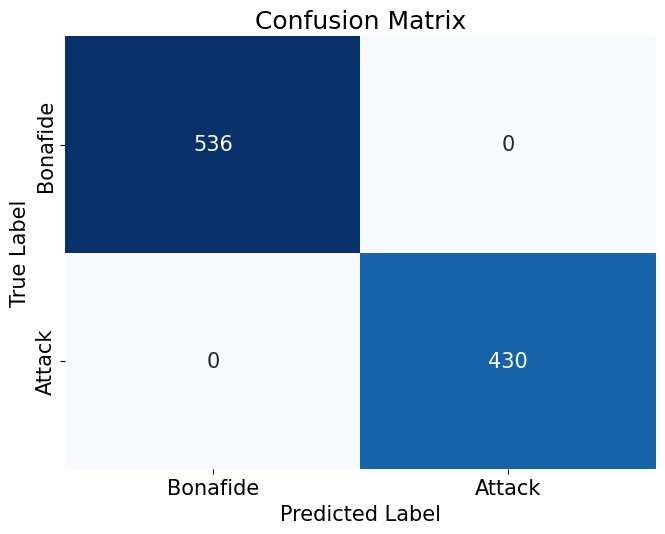

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6.54, 6.54*0.8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Bonafide', 'Attack'], yticklabels=['Bonafide', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig(f"/content/drive/MyDrive/Iris-Presentation-Attack/cm.png", dpi=600)
plt.show()

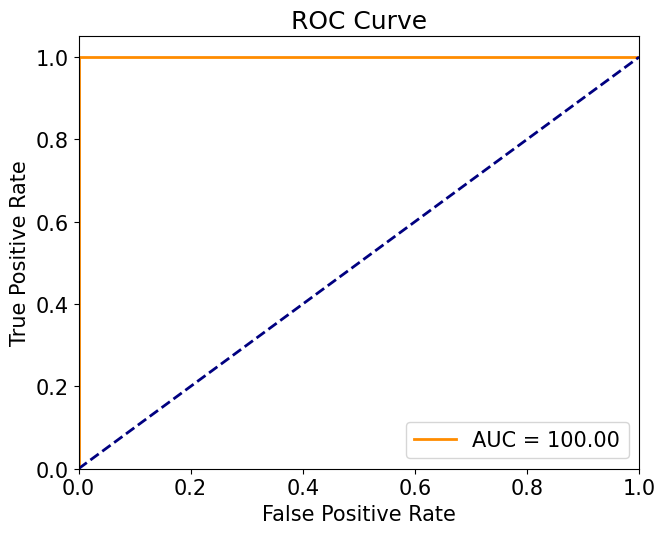

In [15]:
# ROC Curve
plt.figure(figsize=(6.54, 6.54*0.8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig(f"/content/drive/MyDrive/Iris-Presentation-Attack/roc.png", dpi=600)
plt.show()

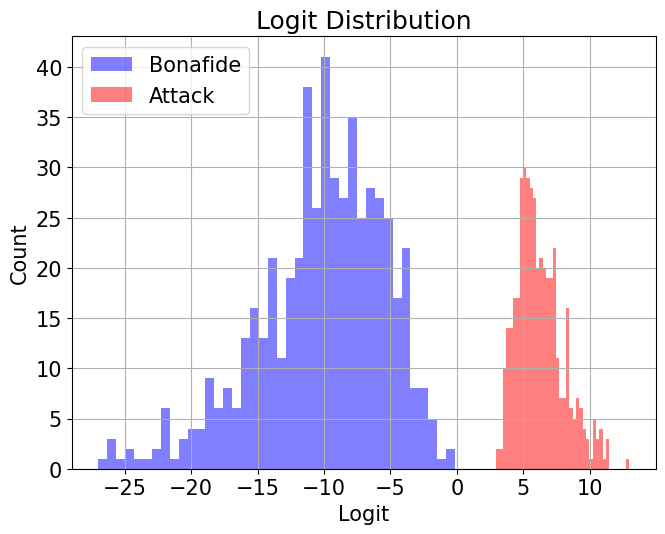

In [16]:
plt.figure(figsize=(6.54, 6.54*0.8))
plt.hist(bona_fide_scores, alpha=0.5, bins=40, label='Bonafide', color='blue')
plt.hist(attack_scores, alpha=0.5, bins=40, label='Attack', color='red')
plt.title('Logit Distribution')
plt.xlabel('Logit')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig(f"/content/drive/MyDrive/Iris-Presentation-Attack/dist.png", dpi=600)
plt.show()

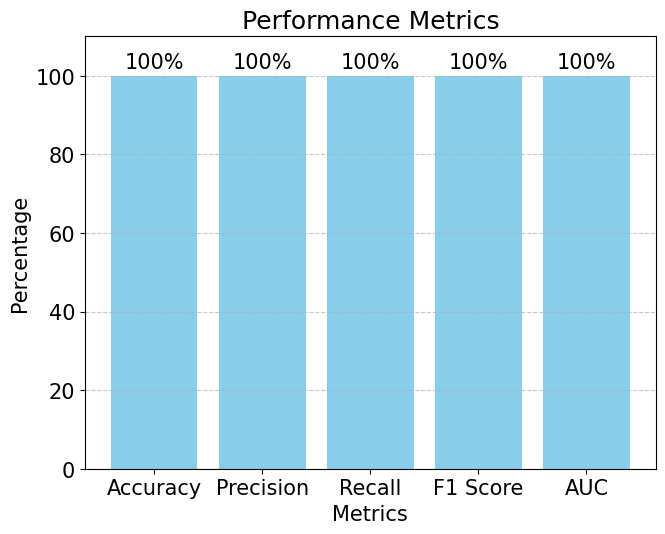

In [19]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
values = [accuracy, precision, recall, f1, roc_auc]

plt.figure(figsize=(6.54, 6.54*0.8))
plt.bar(metrics, values, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Percentage')
plt.title('Performance Metrics')
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding the percentage labels on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 1, f'{value}%', ha='center', va='bottom')

# Save the figure as an image file
plt.savefig('/content/drive/MyDrive/Iris-Presentation-Attack/perm.png', dpi=600)

# Show the plot
plt.show()